# SIRD Model

Assuming a constant mortality rate makes the parameter fitting simpler, which could produce better results.

For example, instead of fitting $$a, b, c$$ in the function $$(a + b + c)*I*S$$, I just let $$d = a + b + c$$, so that I only have to fit $$ d*I*S$$.

### Set up and Data Processing

In [176]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter

In [177]:
# Handle data
# We are given the initial number of dead people, 22
# Assuming that 1% of cases result in death, this gives us an initial removed number of 22*100

who_data = pd.read_csv('cholera_data.csv')

N = 9426017
r_scale = 200.0

I_data = np.array( ( who_data.iloc[:,0]) / N )
R_data = np.array( ( who_data.iloc[:,1]*r_scale ) / N )
D_data = np.array( ( who_data.iloc[:,1]) / N )
S_data = np.array( 1 - I_data - R_data - D_data )

times = who_data.iloc[:,2]

I0 = I_data[0]
R0 = R_data[0]
S0 = S_data[0]
D0 = D_data[0]
W0 = 0.0

### Base Model

In [178]:
def SIRD_model(y,t,alpha,beta, mu, c, h):
    S, I, R, D = y
    dSdt = -(beta)*S*I - c*S*R - h*D
    dIdt = (beta)*S*I- alpha*I - mu*I + c*S*R + h*D
    dRdt = alpha*I 
    dDdt = mu*I 
    
    return dSdt, dIdt, dRdt, dDdt 

In [179]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
h = 0.1
c = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 17
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], I_data[0:num_days], R_data[0:num_days], D_data[0:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, mu, c, h = params['alpha'].value, params['beta'].value, params['mu'].value, params['c'].value, params['h'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, c, h)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=10)
params.add('c', value=c, min=0, max=10)
params.add('h', value=h, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

In [180]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
c = result.params['c'].value
mu = result.params['mu'].value
h = result.params['h'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta,"\nc =", c, "\nh =", h, "\nmu =", mu )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta,  mu, c, h)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.00947530029197674 
beta = 0.034194485133811625 
c = 5.275913039781699e-10 
h = 4.73537128142798e-05 
mu = 1.6653345369377348e-14


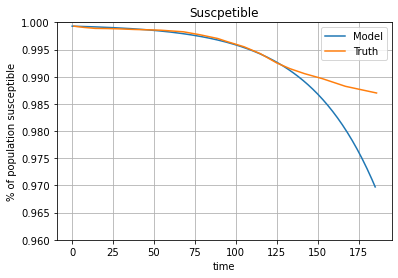

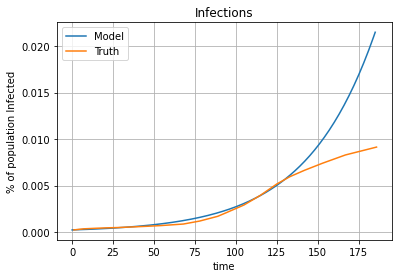

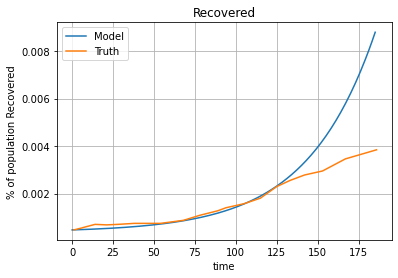

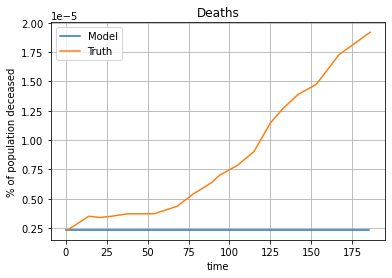

In [181]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.960,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### Improved Model

In [182]:
def SIRD_model(y,t,alpha,beta, beta2, mu, c, h, w_1, w_2, phi, theta):
    S, I, R, D = y
    dSdt = ((theta -beta)*S*I) - (c*S*R) - (h*D) + (beta2*I) - phi*(S*I+I*R)
    dIdt = ((beta - theta)*S*I)  - (w_1*alpha*I + w_2*I) - (mu*I) + (c*S*R) + (h*D) - (beta2*I) + phi*(S*I+I*R)
    dRdt = (w_1*alpha*I + w_2*I)
    #dDdt = (mu*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt 

In [183]:
def SIRD_model2(y,t,alpha,beta, beta2, c, h, phi):
    S, I, R = y
    dSdt = ((-beta)*S*I) - (c*S*R) - (h*R*1/r_scale) + (beta2*I) + phi*(I*R)
    dIdt = ((beta)*S*I)  - (alpha*I) + (c*S*R) + (h*R/r_scale) - (beta2*I) - phi*(I*R)
    dRdt = alpha*I
    
    return dSdt, dIdt, dRdt

# testing model 2

In [184]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
beta2 = 0.1
mu = 0.1
h = 0.1
c = 0.1
phi = 0.1
w_1 = 0.1
w_2 = 0.1
theta = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], 4*I_data[0:num_days], R_data[0:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, beta2, c, h, phi = params['alpha'].value, params['beta'].value, params['beta2'].value, params['c'].value, params['h'].value, params['phi'].value
    # theta = params['theta'].value
    sol = np.array(odeint(SIRD_model2, [S0, I0, R0], tspan, args=(alpha, beta, beta2, c, h, phi)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),4*np.array(sol[:,1]),np.array(sol[:,2])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('beta2', value=beta2, min=0, max=10)
params.add('c', value=c, min=0, max=10)
params.add('h', value=h, min=0, max=10)
params.add('phi', value=phi, min=0, max=10)



result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')
result

In [195]:
def test_control(alpha, beta, beta2,  mu, c, h, w_1, w_2, phi,theta):
    t = np.linspace(0, 1000, 1000)

    #sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, beta2,  mu, c, h, w_1, w_2, phi,theta )))
    sol = np.array(odeint(SIRD_model2, [S0, I0, R0], t, args=(alpha, beta, beta2,  c, h, phi )))
    S_model = sol[:,0]
    I_model = sol[:,1]
    R_model = sol[:,2]
    #D_model = sol[:,3]

    # Start plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    # Plot susceptibles
    ax1.plot(t[0:200], S_model[0:200], label = "Model")
    ax1.plot(times, S_data, label = "Truth")
    ax1.grid()
    ax1.set(xlabel="time", ylabel="% of population susceptible", title = "Suscpetible")

    # Plot removed
    ax3.plot(t[0:200], R_model[0:200])
    ax3.plot(times, R_data)
    ax3.grid()
    ax3.set(xlabel="time", ylabel="% of population removed", title = "Removed")

    # Plot infected
    ax2.plot(t[0:200], I_model[0:200])
    ax2.plot(times, I_data)
    ax2.grid()
    ax2.set(xlabel="time", ylabel="% of population infected", title = "Infected")
    
    
    # Plot deaths
    ax4.plot(t[0:200], R_model[0:200]/r_scale)
    ax4.plot(times, D_data)
    ax4.grid()
    ax4.set(xlabel="time", ylabel="% of population infected", title = "Infected")
 


## Simulate with all controls

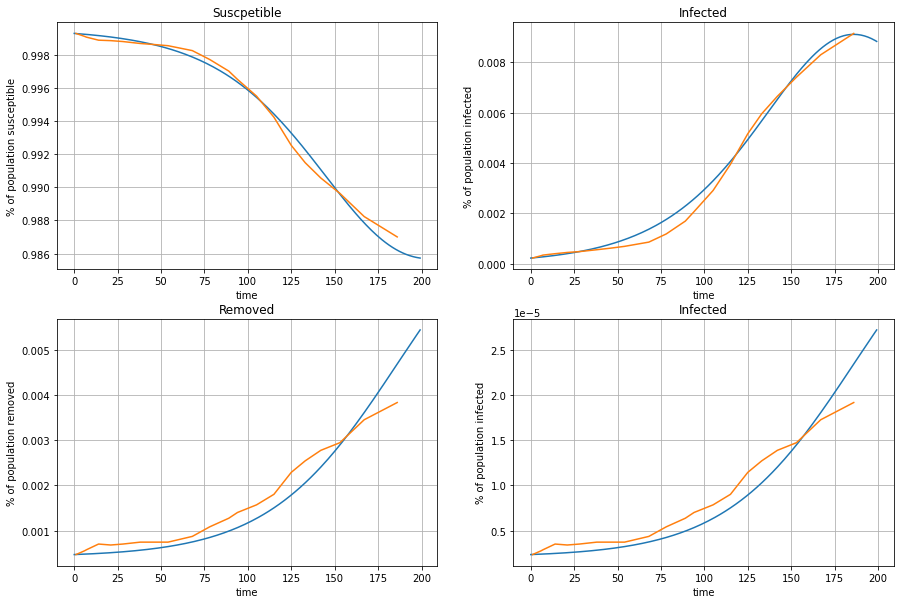

In [196]:
alpha = result.params['alpha'].value
beta = result.params['beta'].value
beta2 = result.params['beta2'].value
c = result.params['c'].value
h = result.params['h'].value
phi = result.params['phi'].value

test_control(alpha, beta, beta2,  mu, c, h, w_1, w_2, phi,theta)
params
result

## Simulation of control 1

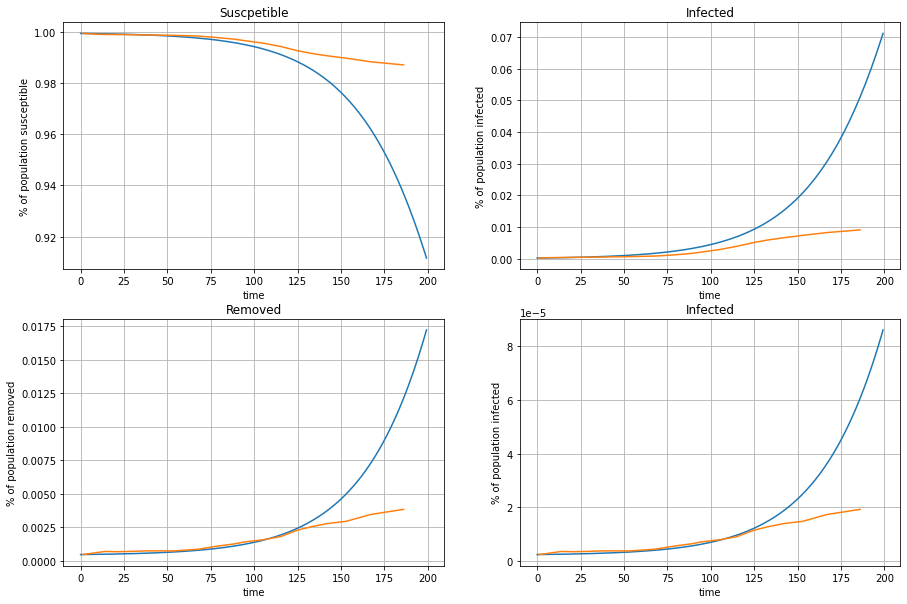

In [197]:
# Control 1
beta2 = result.params['beta2'].value

# Turn off other controls
phi = 0
w_1 = 0
w_2 = 0
theta = 0

# Set base model parameters
alpha = result.params['alpha'].value
beta = result.params['beta'].value
h = result.params['h'].value
c = result.params['c'].value

# Simulate
test_control(alpha, beta, beta2,  mu, c, h, w_1, w_2, phi,theta)

## Simulation of control 2

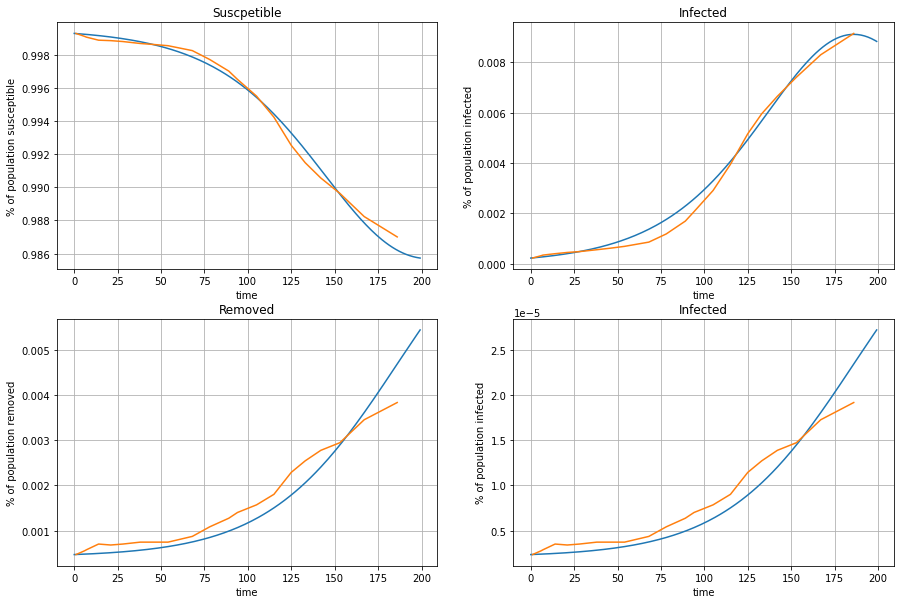

In [198]:
# Turn on control 2
phi = result.params['phi'].value

# Turn off other controls
mu = 0
w_1 = 0
w_2 = 0
theta = 0

# Set base model parameters
alpha = result.params['alpha'].value
beta = result.params['beta'].value
h = result.params['h'].value
c = result.params['c'].value
#mu = result.params['mu'].value

# Simulate
test_control(alpha, beta, beta2,  mu, c, h, w_1, w_2, phi,theta)

## Simulation of control 3

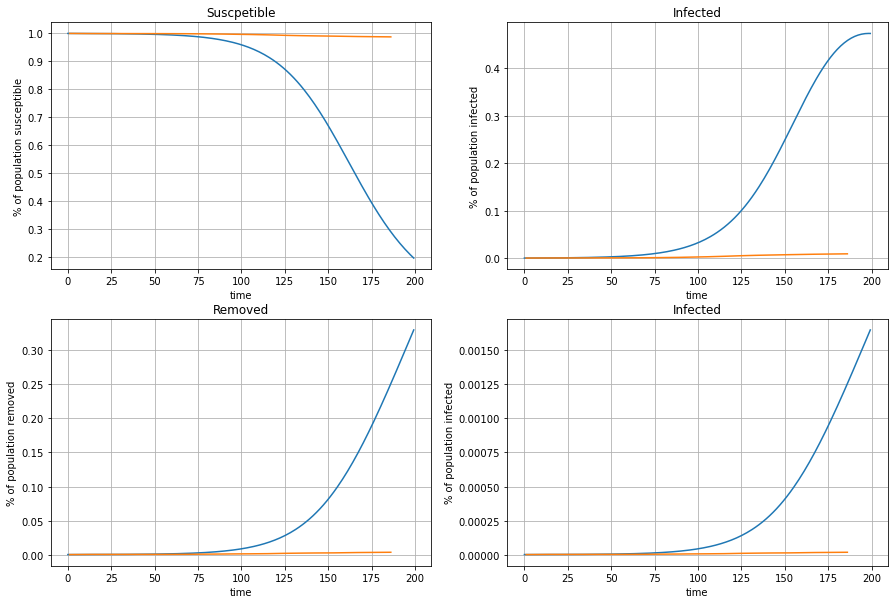

In [199]:
# Turn on control 3

# Turn off other controls
mu = 0
phi = 0
beta2 = 0

# set base model parameters
alpha = result.params['alpha'].value
beta = result.params['beta'].value
h = result.params['h'].value
c = result.params['c'].value

alpha = alpha*2

# Simulate
test_control(alpha, beta, beta2,  mu, c, h, w_1, w_2, phi,theta)

## Simulation of control 4

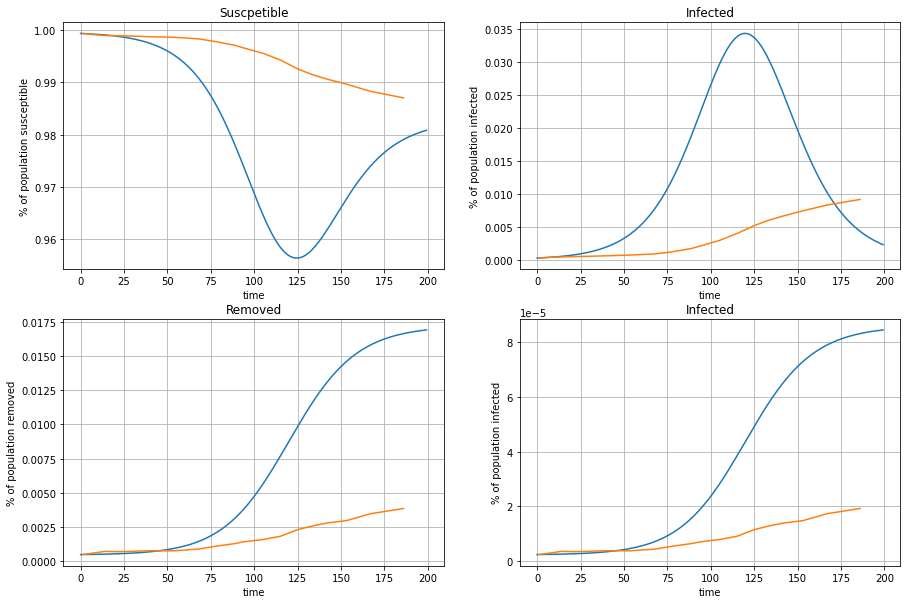

In [200]:
# Turn on control 4
phi = result.params['phi'].value

# Turn off other controls
beta2 = 0
w_1 = 0
w_2 = 0
theta = 0

# set base model parameters
alpha = result.params['alpha'].value
beta = result.params['beta'].value
h = result.params['h'].value
c = result.params['c'].value
#mu = result.params['mu'].value

# Simulate
test_control(alpha, beta, beta2,  mu, c, h, w_1, w_2, phi,theta)

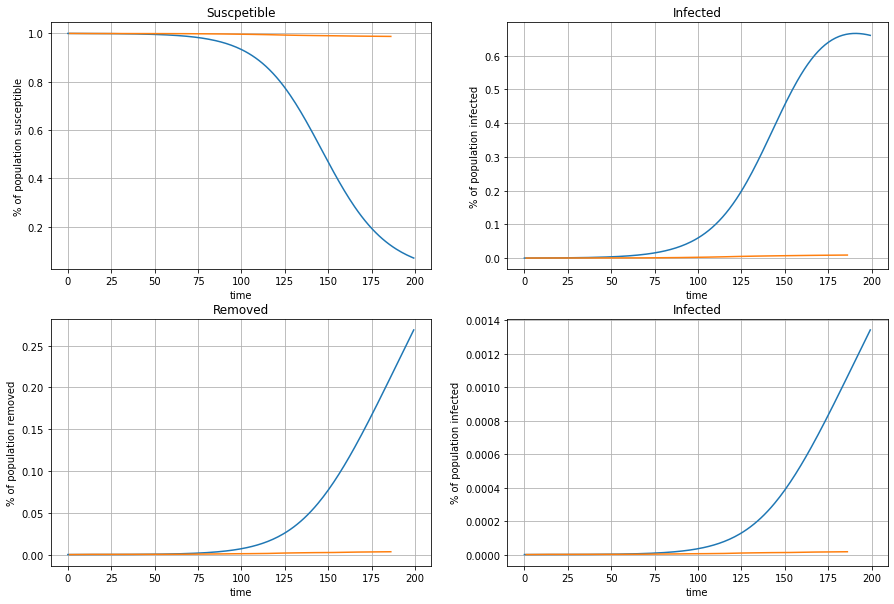

In [201]:
# Turn off all controls
phi = 0
beta2 = 0
w_1 = 0
w_2 = 0
theta = 0

# set base model parameters
alpha = result.params['alpha'].value
beta = result.params['beta'].value
h = result.params['h'].value
c = result.params['c'].value
#mu = result.params['mu'].value

# Simulate
test_control(alpha, beta, beta2,  mu, c, h, w_1, w_2, phi,theta)

In [165]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
alpha,0.00636553,5.2224e-04,(8.20%),0.1,0.00000000,10.0000000,True
beta,0.06275237,1.59680817,(2544.62%),0.1,0.00000000,10.0000000,True
beta2,0.02657137,1.59430332,(6000.08%),0.1,0.00000000,10.0000000,True
c,8.1919e-07,0.00652134,(796075.38%),0.1,0.00000000,10.0000000,True
h,2.9573e-09,0.37483933,(12675207348.12%),0.1,0.00000000,10.0000000,True
phi,6.16719434,5.12178732,(83.05%),0.1,0.00000000,10.0000000,True
